In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

import sys
sys.path.insert(0, './')

def generateModelV2(working_directory, 
                    number_directory=0, 
                    number_images=0,
                    #number_cluster=10,
                    descriptor_generator="SIFT", 
                    number_feature=200,
                    minimum_size_descriptor=20, 
                    version=""
                   ):
    start_time_model = time.time()

    # class de travail
    from Python.automaticImageIndexing import AutomaticImageIndexing
    automaticImageIndexing = AutomaticImageIndexing()

    print(''.join(['Version : ', automaticImageIndexing.version()]))
    print(''.join(['Data directory : ', automaticImageIndexing.data_directory]))

    automaticImageIndexing.n_limite_directories = number_directory
    automaticImageIndexing.n_limite_images = number_images
    print(''.join(['Max Number of directory : ', str(automaticImageIndexing.n_limite_directories)]))
    print(''.join(['Max Number of picture by directory : ', str(automaticImageIndexing.n_limite_images)]))

    automaticImageIndexing.working_directory = working_directory#'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
    automaticImageIndexing.annotation_directory = 'annotation/'
    automaticImageIndexing.picture_directory = 'images/'
    
    automaticImageIndexing.feature_generator = descriptor_generator
    print('Generator : %s' % automaticImageIndexing.feature_generator)
    automaticImageIndexing.n_feature = number_feature 
    print('Number of feature : %d' % automaticImageIndexing.n_feature)
    automaticImageIndexing.feature_size_min = minimum_size_descriptor
    print('Minimum feature size  %d' % automaticImageIndexing.n_feature)
    
    automaticImageIndexing.read_picture_and_feature_generation(with_sub_picture=True, descriptor_generator=descriptor_generator, version=version)
    print("Temps d execution apres parcour image + ORB : %s secondes ---" % (time.time() - start_time_model))

    return automaticImageIndexing

def generateCluster(automaticImageIndexing, number_cluster=None, mode_affichage="", number_cluster_to_show=None):
    start_time_cluster = time.time()
    if(number_cluster is None):
        number_cluster = int(10)
    automaticImageIndexing.n_clusters = number_cluster
    
    automaticImageIndexing.clusturing(automaticImageIndexing.n_clusters)
    print("Temps d execution apres Clustering : %s secondes ---" % (time.time() - start_time_cluster))
    mega_histo = automaticImageIndexing.developBagOfVisualWord()
    print("Temps d execution apres BOV : %s secondes ---" % (time.time() - start_time_cluster))
    automaticImageIndexing.plotHist(mega_histo, automaticImageIndexing.n_clusters, None)
    print("Temps d execution après plot BOV : %s secondes ---" % (time.time() - start_time_cluster))

    if number_cluster_to_show is None :
        number_cluster_to_show = int(number_cluster/2)
    showClusterPicture(
        automaticImageIndexing=automaticImageIndexing,
        mode_affichage=mode_affichage,
        number_cluster_to_show=number_cluster_to_show
    )

def showClusterPicture(automaticImageIndexing, mode_affichage="", number_cluster_to_show=None):
    start_time_showing = time.time()

    if automaticImageIndexing.n_clusters is None:
        print("Veuillez entrainer le model (& generer les cluster) ---")
    else:
        if number_cluster_to_show is None :
            number_cluster_to_show = int(automaticImageIndexing.n_clusters/2)

        if (mode_affichage == "subplot" or mode_affichage == "all"):
            print("affichage subplot des images liées au cluster %d" % number_cluster_to_show)
            automaticImageIndexing.plot_descriptor_in_cluster_subplot_V2(number_cluster_to_show)
            print("Temps d execution apres subplot : %s secondes ---" % (time.time() - start_time_showing))

        if (mode_affichage == "individual_plot" or mode_affichage == "all"):
            print("affichage individuel des images liées au cluster %d" % number_cluster_to_show)
            automaticImageIndexing.plot_descriptor_in_cluster_individualplot(number_cluster_to_show)        
            print("Temps d execution apres individual_plot : %s secondes ---" % (time.time() - start_time_showing))
    


In [2]:
def k_mean_distance_decriptor(data, cantroid_matrix, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid
    distances = [np.linalg.norm(x-cantroid_matrix) for x in data[cluster_labels == i_centroid]]
    # return the mean value
    return np.nanmean(distances), np.nanmin(distances), np.nanmax(distances), len(distances)

def k_mean_distance_all_cluster(model):
    distances = []
    clusters_rates = []
    data = model.np.array(model.desc_list)
    for i_centroid, cantroid_matrix in enumerate(model.kmeans_obj.cluster_centers_):
        # Calculate Euclidean distance for each data point assigned to centroid
        distances = distances + [model.np.linalg.norm(x-cantroid_matrix) for x in data[model.kmeans_ret == i_centroid]]
        # Calculate the rate of cluster for each centroid
        clusters_rates.append(len(data[model.kmeans_ret == i_centroid]))
    return model.np.nanmean(distances), model.np.nanmin(distances), model.np.nanmax(distances), model.np.nanmean(clusters_rates)

def findBestCluster(automaticImageIndexing, number_cluster_min=0, number_cluster_max=100, number_cluster_step=25, show_intermediate_distance=None):
    start_time_cluster_optimizing = time.time()
    
    if automaticImageIndexing.n_clusters is None:
        print("Veuillez entrainer le model (et generer les clusters) ---")
    else:
        result = []
        nb_descriptor_total = len(automaticImageIndexing.desc_list) * 1.0 #1.0 to convert int in decimal
        print("nb descriptor : %s" % nb_descriptor_total)
        
        mean_distances_all_cluster = []
        max_distances_all_cluster = []
        min_distances_all_cluster = []
        perform_indicator_nb_descriptor_all_cluster=[]
        perform_indicator_descripor_all_cluster=[]

        for nb_cluster in range(number_cluster_min, number_cluster_max, number_cluster_step):
            print("-----------------------------------------------------------------------------------------")
            print("--------------------------------- start test cluster %s ---------------------------------" % str(nb_cluster))
            generateCluster(
                automaticImageIndexing=automaticImageIndexing,
                number_cluster=nb_cluster
            )
            
            centroids = model.kmeans_obj.cluster_centers_            
            if show_intermediate_distance == True:
                mean_distances = []
                max_distances = []
                min_distances = []
                descriptors_rate = []
                for i, cent_features in enumerate(centroids):
                    mean_distance, max_distance, min_distance, number_descriptor = k_mean_distance_decriptor(
                        automaticImageIndexing.np.array(automaticImageIndexing.desc_list), 
                        cent_features,
                        i,
                        automaticImageIndexing.kmeans_ret
                    )
                    mean_distances.append(mean_distance)
                    max_distances.append(max_distance)
                    min_distances.append(min_distance)
                    
                    perform_indicator_descripor = (number_descriptor / nb_descriptor_total)
                    descriptors_rate.append(perform_indicator_descripor)
                fig, axs = automaticImageIndexing.plt.subplots(nrows=1, ncols=2, constrained_layout=False)
                clusters_numero = range(nb_cluster)
                axs[0].plot(clusters_numero, mean_distances)
                axs[0].plot(clusters_numero, max_distances)
                axs[0].plot(clusters_numero, min_distances)
                
                axs[0].set_xlabel('Cluster', fontsize=12)
                axs[0].set_ylabel('Distance', fontsize=12)
                axs[0].set_title('Distances by Cluster', fontsize=12)
                
                axs[1].plot(clusters_numero, descriptors_rate)
                
                axs[1].set_xlabel('Cluster', fontsize=12)
                axs[1].set_ylabel('Descriptor Rate', fontsize=12)
                axs[1].set_title('Descriptor Rate by cluster', fontsize=12)
                automaticImageIndexing.plt.show()
            
            mean_distance_all_cluster, max_distance_all_cluster, min_distance_all_cluster, mean_number_descriptor = k_mean_distance_all_cluster(
                automaticImageIndexing
            )
            mean_distances_all_cluster.append(mean_distance_all_cluster)
            max_distances_all_cluster.append(max_distance_all_cluster)
            min_distances_all_cluster.append(min_distance_all_cluster)
            
            print(mean_number_descriptor)
            print(nb_descriptor_total)
            
            print(mean_number_descriptor / nb_descriptor_total)
            
            perform_indicator_distance = mean_number_descriptor / nb_descriptor_total
            
            perform_indicator_nb_descriptor_all_cluster.append(perform_indicator_distance)
            
            print("--------------------------------- sop test cluster %s ---------------------------------" % str(nb_cluster))
    clusters_numbers = range(number_cluster_min, number_cluster_max, number_cluster_step)
    
    fig, axs = automaticImageIndexing.plt.subplots(nrows=1, ncols=2, constrained_layout=False)
    axs[0].plot(clusters_numbers, mean_distances_all_cluster, label="mean")
    axs[0].plot(clusters_numbers, max_distances_all_cluster, label="max")
    axs[0].plot(clusters_numbers, min_distances_all_cluster, label="min")

    axs[0].set_xlabel('Cluster', fontsize=12)
    axs[0].set_ylabel('Distance moyenne', fontsize=12)
    axs[0].set_title('Distances moyenne by number of Cluster', fontsize=12)

    axs[1].plot(clusters_numbers, perform_indicator_nb_descriptor_all_cluster, label="indicateur Nb Descripteur moyen")

    axs[1].set_xlabel('Cluster', fontsize=12)
    axs[1].set_ylabel('Descriptor Rate', fontsize=12)
    axs[1].set_title('Descriptor Rate by number of Cluster', fontsize=12)
    #automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.divide(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.divide(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.divide(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.divide(perform_indicator_nb_descriptor_all_cluster,mean_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.divide(perform_indicator_nb_descriptor_all_cluster,min_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.divide(perform_indicator_nb_descriptor_all_cluster,max_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.multiply(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.multiply(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.multiply(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    print("array normalisees")
    
    mean_distances_all_cluster = normalize([mean_distances_all_cluster], axis=1, norm='l1')[0]
    max_distances_all_cluster = normalize([max_distances_all_cluster], axis=1, norm='l1')[0]
    min_distances_all_cluster = normalize([min_distances_all_cluster], axis=1, norm='l1')[0]
    perform_indicator_nb_descriptor_all_cluster = normalize([perform_indicator_nb_descriptor_all_cluster], axis=1, norm='l1') [0]   
    
    fig, axs = automaticImageIndexing.plt.subplots(nrows=1, ncols=2, constrained_layout=False)
    axs[0].plot(clusters_numbers, mean_distances_all_cluster, label="mean")
    axs[0].plot(clusters_numbers, max_distances_all_cluster, label="max")
    axs[0].plot(clusters_numbers, min_distances_all_cluster, label="min")

    axs[0].set_xlabel('Cluster', fontsize=12)
    axs[0].set_ylabel('Distance moyenne', fontsize=12)
    axs[0].set_title('Distances moyenne by number of Cluster', fontsize=12)

    axs[1].plot(clusters_numbers, perform_indicator_nb_descriptor_all_cluster, label="indicateur Nb Descripteur moyen")

    axs[1].set_xlabel('Cluster', fontsize=12)
    axs[1].set_ylabel('Descriptor Rate', fontsize=12)
    axs[1].set_title('Descriptor Rate by number of Cluster', fontsize=12)
    #automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.divide(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.divide(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.divide(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.divide(perform_indicator_nb_descriptor_all_cluster,mean_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.divide(perform_indicator_nb_descriptor_all_cluster,min_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.divide(perform_indicator_nb_descriptor_all_cluster,max_distances_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    perfs_mean = np.multiply(mean_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_mean, label="mean")
    perfs_min = np.multiply(min_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_min, label="min")
    perfs_max = np.multiply(max_distances_all_cluster,perform_indicator_nb_descriptor_all_cluster)
    automaticImageIndexing.plt.plot(clusters_numbers, perfs_max, label="max")
    
    
    automaticImageIndexing.plt.legend()
    automaticImageIndexing.plt.show()
    
    print("Temps d execution optimisation : %s secondes ---" % (time.time() - start_time_cluster_optimizing))


Version : 0.4
Data directory : Data/
Max Number of directory : 2
Max Number of picture by directory : 2
Generator : ORB
Number of feature : 6000
Minimum feature size  6000
Computing Features for  n02085620-Chihuahua
Computing Features for  n02085782-Japanese_spaniel
Temps d execution apres parcour image + ORB : 0.735000133514 secondes ---
nb descriptor : 10559.0
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 1 ---------------------------------
Temps d execution apres Clustering : 0.161999940872 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 0.161999940872 secondes ---
Plotting histogram


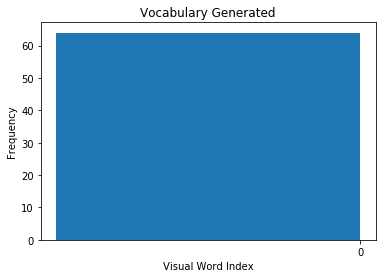

Temps d execution après plot BOV : 0.335999965668 secondes ---


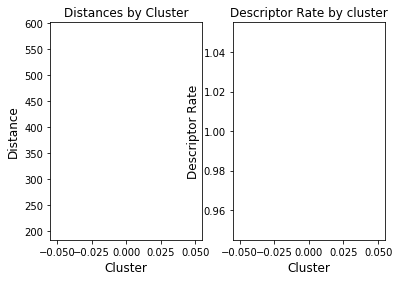

10559.0
10559.0
1.0
--------------------------------- sop test cluster 1 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 2 ---------------------------------
Temps d execution apres Clustering : 0.705999851227 secondes ---
Vocabulary Histogram Generated
Temps d execution apres BOV : 0.705999851227 secondes ---
Plotting histogram


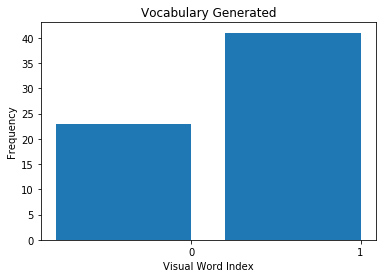

Temps d execution après plot BOV : 0.816999912262 secondes ---


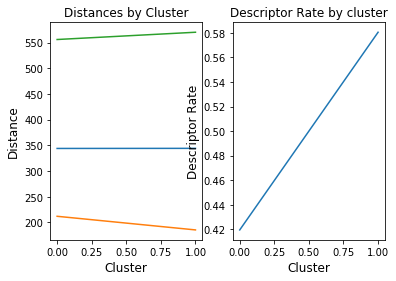

5279.5
10559.0
0.5
--------------------------------- sop test cluster 2 ---------------------------------
-----------------------------------------------------------------------------------------
--------------------------------- start test cluster 3 ---------------------------------


KeyboardInterrupt: 

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=6000,
        number_directory=2,#40, 
        number_images=2,#20,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 1
stop = 4
step = 1
tableau_perf = findBestCluster(model, start, stop, step,
        show_intermediate_distance=True)
tableau_perf

In [ ]:
start = 10
stop = 500
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=100,#40, 
        number_images=2,#20,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 1000
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=100, 
        number_images=20,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 500
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=100, 
        number_images=20,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 1
stop = 250
step = 5
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=20,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 250
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=50,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 250
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=100,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 250
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'
model = generateModelV2(
        working_directory=working_space,
        number_feature=60,
        number_directory=0, 
        number_images=0,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

start = 10
stop = 250
step = 25
tableau_perf = findBestCluster(model, start, stop, step)
tableau_perf

In [ ]:
def generateClusterAndTrainModel(automaticImageIndexing, number_cluster=None, mode_affichage="", number_cluster_to_show=None):
    start_time_cluster = time.time()
    if(number_cluster is None):
        number_cluster = int(10)
    automaticImageIndexing.n_clusters = number_cluster
    
    automaticImageIndexing.clusturing(automaticImageIndexing.n_clusters)
    print("Temps d execution apres Clustering : %s secondes ---" % (time.time() - start_time_cluster))
    mega_histo = automaticImageIndexing.developBagOfVisualWord()
    print("Temps d execution apres BOV : %s secondes ---" % (time.time() - start_time_cluster))
    automaticImageIndexing.plotHist(mega_histo, automaticImageIndexing.n_clusters, None)
    print("Temps d execution après plot BOV : %s secondes ---" % (time.time() - start_time_cluster))

    if number_cluster_to_show is None :
        number_cluster_to_show = int(number_cluster/2)
    showClusterPicture(
        automaticImageIndexing=automaticImageIndexing,
        mode_affichage=mode_affichage,
        number_cluster_to_show=number_cluster_to_show
    )
    print automaticImageIndexing.name_dict
    

    print mega_histo
    automaticImageIndexing.mega_histo = automaticImageIndexing.standardize(mega_histo)
    print mega_histo
    print automaticImageIndexing.mega_histo
    automaticImageIndexing.model_predition = automaticImageIndexing.train( automaticImageIndexing.mega_histo, automaticImageIndexing.name_dict)
    return automaticImageIndexing.model_predition
    

In [ ]:
working_space = 'C:/Users/naru_/OneDrive/Documents/openclassroom/P7 traitement image/'

nb_cluster = 2#235

model = generateModelV2(
        working_directory=working_space,
        number_feature=75,
        number_directory=2,#0, 
        number_images=2,#100,
        descriptor_generator="ORB",
        minimum_size_descriptor=20
    )

print("-----------------------------------------------------------------------------------------")
print("--------------------------------- Génération %s cluster - Start ---------------------------------" % str(nb_cluster))
modelPrediction = generateClusterAndTrainModel(
        model,
        number_cluster=nb_cluster
    )
print("--------------------------------- Génération %s cluster - Start ---------------------------------" % str(nb_cluster))